<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/Basic_nns_dls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moons dataset

## Imports

In [172]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


import torch
from torch import nn
from torch.nn import functional as F


from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## Freeze seeds

In [103]:
np.random.seed(42)
torch.manual_seed(42)

## Generate dataset

In [16]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

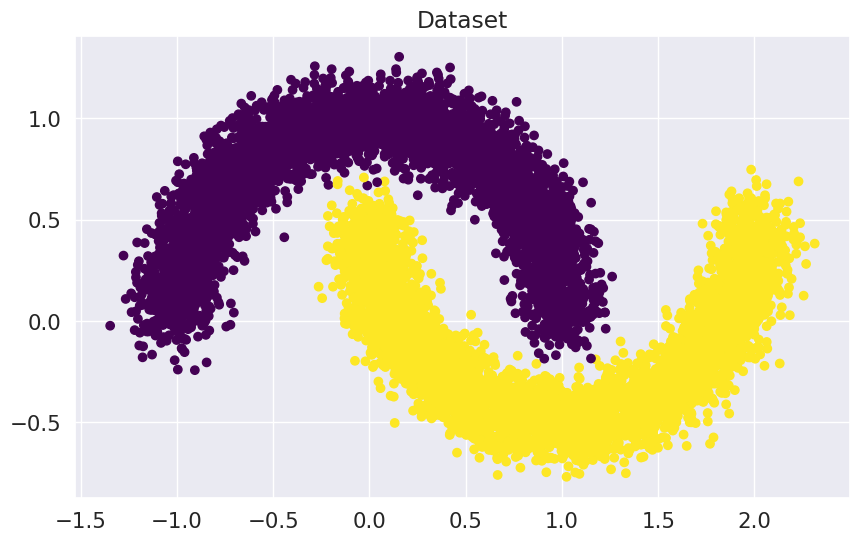

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

## Split data into train and val dfs

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Task 1: Create tensors converting to torch.float32 and load using TensorDataset

In [19]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

In [160]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Implement Linear regression

In [98]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights.T
        if self.bias:
            x +=  self.bias_term
        return x

In [104]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

#### Question 1: How many trainable parameters are there in the class?

In [80]:
result = sum([p.numel() for p in linear_regression.parameters() if p.requires_grad])
print(f'Answer: There are {result} trainable parameters')

Answer: There are 3 trainable parameters


The answer is 3

### Task 2: Implement training cycle

In [113]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            iterations = {'iteration on batch':it,
                          'curr_epoch':epoch,
                          'batch_size':len(train_dataloader),
                          'total_iterations': it + epoch * len(train_dataloader)}
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.78125
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.90625

Iteration: 346.Convergence. Stopping iterations.


#### Question 2: How many iteration is required to converge?

In [114]:
iterations

{'iteration on batch': 51,
 'curr_epoch': 5,
 'batch_size': 59,
 'total_iterations': 346}

Depends on how the weights and biases (mostly weights)are initialized. Sometimes it takes over900, sometimes much less.
In this case: 51 iterations with a batch size of 59 on the 5th epoch totalling to 346 iterations

### Visualize

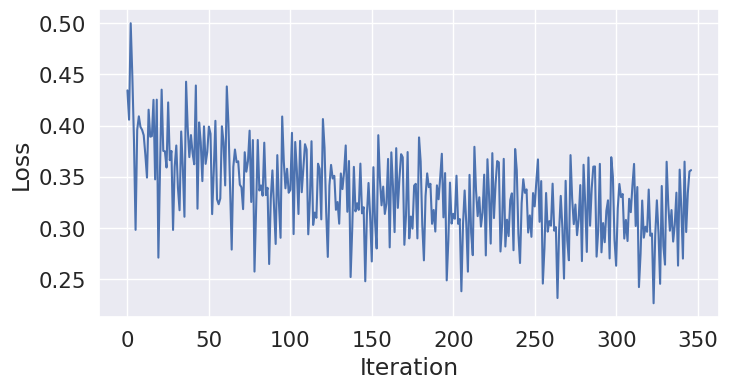

In [116]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

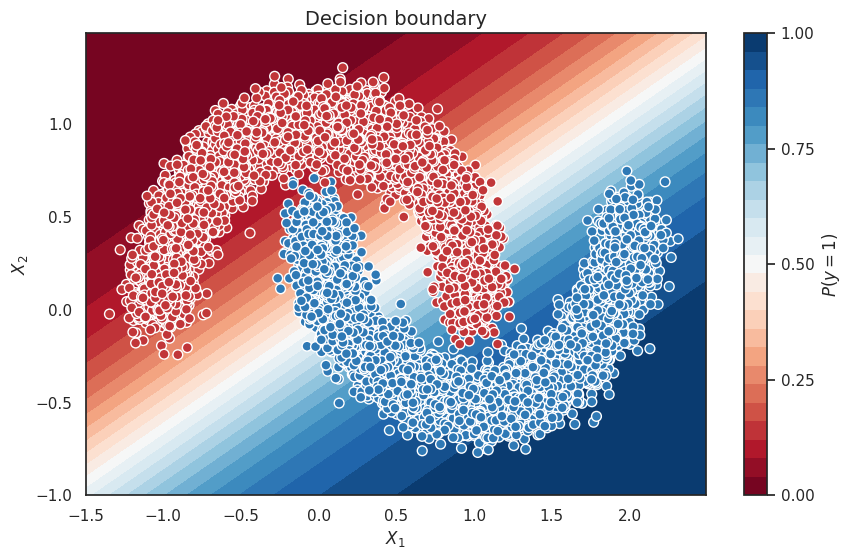

In [118]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Task 3: Implement predict function and calculate accuracy score on test

In [161]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch))
        predictions = np.hstack((predictions, preds.numpy().flatten()))

    # Handle the incomplete batch since otherwise DataLoader would just create
    # additional rows mismathing dimensions
    if len(predictions) != len(dataloader.dataset):
        last_batch_size = len(dataloader.dataset) % dataloader.batch_size
        x_last_batch, _ = dataloader.dataset[-last_batch_size:]
        preds_last_batch = torch.sigmoid(model(x_last_batch))
        predictions = np.hstack((predictions, preds_last_batch.numpy().flatten()[:last_batch_size]))

    return predictions.flatten()[:len(dataloader.dataset)]


In [171]:
val_predictions = predict(val_dataloader, linear_regression)
val_pred_labels = (val_predictions > 0.5).astype(int)
print(f'Accuracy: {accuracy_score(val_pred_labels, y_val_t)*100:.2f}%')

Accuracy: 85.44%


In [175]:
report = classification_report(y_val_t, val_pred_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      1272
         1.0       0.85      0.85      0.85      1228

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



#### Question 3: What's the accuracy after training?

On this particular run, using that state if initalized weight, parameters and on that training, it's 85.44%. Weighted average accuracy is 85% as well.